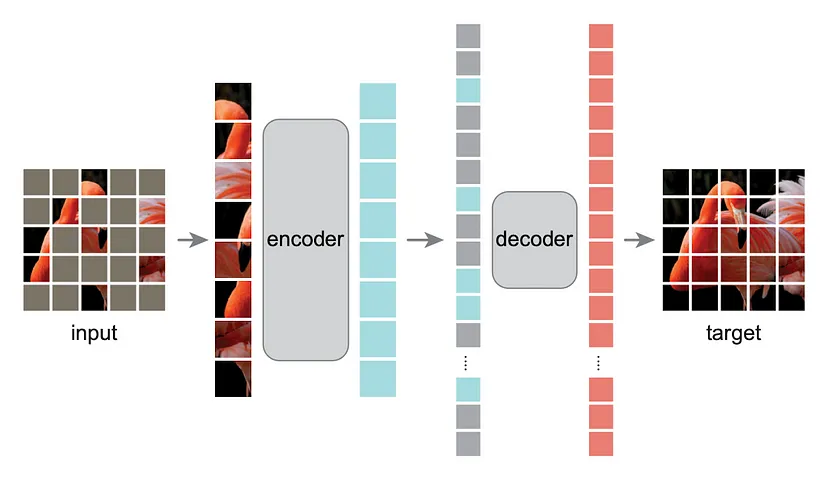

In [ ]:
# Note: Due to the proprietary nature of our dataset, I've chosen to use another public dataset
# from kaggle which has several classes of food items.

## Importing Libraries

In [1]:
import os
import shutil
import random
import torch
import pickle
import cv2 as cv
import numpy as np
import pandas as pd
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

In [2]:
# Loading the relevant data.
fnames_train = os.listdir("D:/fastfooddataset/Fast Food Classification V2/AllValid")

In [3]:
# pacp dataset class creation.
class pacp(Dataset):
    """Custom dataset class for the pacp-dataset"""
    def __init__(self, fnames, root_dir, transform=True):
        """
        Args:
            fnames (list): List of all the file names.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.fnames = fnames
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def patching(self,img,r=0.75,patch_size=16): # Mask 80% of patches by default
        """Code to create patches to pass to the MAE"""
        # Create patches
        C,H,W = img.shape
        img = img.reshape(C,H//patch_size,patch_size,W//patch_size,patch_size)
        img = img.permute(1,3,0,2,4)
        img = img.flatten(3,4) # torch.Size([15,15,3,1024])
        img = img.flatten(2,3) # torch.Size([15, 15, 3072])
        img = img.flatten(0,1) # torch.Size([225, 3072])
        return img

    def __getitem__(self, idx):
        scaler = transforms.Resize((256, 256),antialias=True) # Resize the values to make the image square for the
        # transformer. 480 is a decent number based on the dimensions of the images in the dataset.
        # These mean and std values are of the pacp dataset
        normalize = transforms.Normalize(mean=[0.681, 0.570, 0.467],
                                 std=[0.278, 0.297, 0.332])
        to_tensor = transforms.ToTensor()

        img_name = os.path.join(self.root_dir,self.fnames[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert from BGR to RGB
        plt.imshow(image)
        if self.transform:
            image = normalize(scaler(to_tensor(image)))
        # Create patches to pass to the masked autoencoder
        image = self.patching(image)
        return image

In [4]:
pacp_dataset = {
    'train': pacp(fnames_train,"/content/drive/Othercomputers/My Laptop/AllValid",transform=True)
}
print("Length of training dataset:",pacp_dataset['train'].__len__())

Length of training dataset: 3500


In [5]:
# Parameters for loading data
params_train = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 8}

params_test = {'batch_size': 64,
                'shuffle': False,
                'num_workers': 2}

dataloaders = {
    'train':DataLoader(pacp_dataset['train'],**params_train)
    # 'test':DataLoader(pacp_dataset['test'],**params_test)
}

## MaskedAutoEncoder implementation

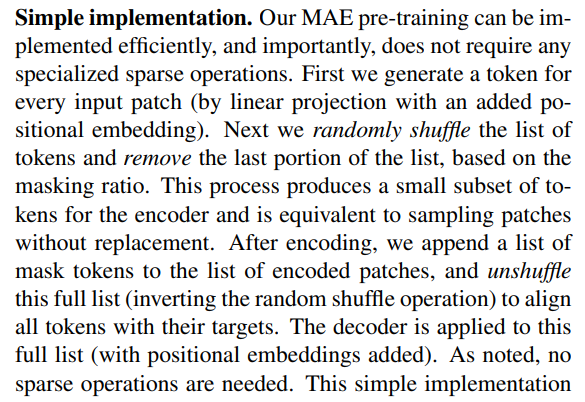

In [6]:
# Defining the Encoder
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(EncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, embed_dim),
        )
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + self.dropout(attn_output)
        x_norm = self.norm2(x)
        ffn_output = self.ffn(x_norm)
        x = x + self.dropout(ffn_output)
        return x


class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_blocks):
        super(Encoder, self).__init__()
        self.embeddings = nn.Linear(input_dim, embed_dim, bias=True)
        self.pos_embed = nn.Parameter(torch.randn(1, 256, embed_dim))
        self.enc = nn.Sequential(
            *(EncoderBlock(embed_dim, num_heads) for _ in range(num_blocks))
        )

    def forward(self, x, indices):
        x = self.embeddings(x) + self.pos_embed
        # Shuffle patches randomly and clip off 180 patches towards the end (masked)
        x_new = x.permute(1,0,2)
        x_new = x_new[indices].permute(1,0,2)
        x_new = x_new[:,:64,:] # Choosing only 64 tokens. The others are removed.
#         print("Shape of input to encoder transformer",x_new.shape)
        x = x_new.transpose(0,1) #Cuz of how the transformer expects the input
        x = self.enc(x)
        x = x.transpose(0,1)
        return x

In [7]:
# Defining the Decoder
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(DecoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, embed_dim),
        )
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + self.dropout(attn_output)
        x_norm = self.norm2(x)
        ffn_output = self.ffn(x_norm)
        x = x + self.dropout(ffn_output)
        return x


class Decoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_blocks):
        super(Decoder, self).__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, 256, embed_dim))
        self.dec = nn.Sequential(
            *(DecoderBlock(embed_dim, num_heads) for _ in range(3)) # Have only 4 decoder blocks for now.
        )

    def forward(self, x):
        x = x + self.pos_embed
        x = x.transpose(0,1)
        x = self.dec(x)
        x = x.transpose(0,1)
#         print("Shape of output from the decoder",x.shape)
        return x

In [8]:
# Defining the MaskedAutoEncoder which uses the encoder and the decoder.
class MaskedAutoEncoder(nn.Module):
    def __init__(self, input_dim=256*3, embed_dim=1024, num_heads=8, num_blocks=8):
        super(MaskedAutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        # Initializing the mask tokens to be used by the decoder.
        self.mask_tokens = torch.randn(1,1,1024)
        self.mask_tokens = nn.Parameter(self.mask_tokens.repeat(12,192,1).to(device)) # Making the mask tokens learnable parameters
        # 192 corresponding to the 192 masked patches
        # Encoder block
        self.encoder = Encoder(input_dim, embed_dim, num_heads, num_blocks)
        # Decoder block
        self.decoder = Decoder(embed_dim, num_heads, num_blocks)
        # Final layer to reconstruct the patches
        self.final_layer = nn.Linear(embed_dim, input_dim)

    def forward(self, x):
        # Create high dimensional embeddings from the non-masked image patches
        indices = torch.arange(start=0,end=x.shape[1])
        # Shuffle the indices
        indices = indices[torch.randperm(len(indices))]
        x = self.encoder(x,indices)
        # Pass the embedding through the decoder block
#         print("Dimensions of output after passing through encoder",x.shape)

        # Appending mask tokens to the end and inverse shuffling
        x_old = torch.cat((x,self.mask_tokens),dim = 1)
#         print(x_old.shape)
        # Getting back the original order of the tokens
        x_orig = torch.zeros(12,256,1024).to(device)
        x_orig = x_orig.permute(1,0,2)
        x_orig[indices] = x_old.permute(1,0,2)
        x = x_orig.permute(1,0,2)
#         print("Dimensions of input to the decoder",x.shape)
        x = self.decoder(x)
#         print("OUT OF DECODER", x.shape)
        x = self.final_layer(x)
#         print("After final layer",x.shape)
        return indices,x

## Train the model

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the autoencoder
mae = MaskedAutoEncoder()
# Load the model parameters
# checkpoint_path = '/content/drive/MyDrive/Ruthvik/mae_epochoverfit_1.pth'  # Replace with your checkpoint path
# mae.load_state_dict(torch.load(checkpoint_path), strict=False)

mae = mae.to(device)  # Move the model to GPU

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(mae.parameters())
# optimizer = torch.optim.SGD(mae.parameters(), lr=0.01)

# Training loop
num_epochs = 2000

# Define list to hold loss values for each epoch
loss_values = []

for epoch in range(num_epochs):
    print("Epoch:", epoch)

    # Define variable to accumulate loss over all batches in an epoch
    epoch_loss = 0.0
    num_batches = 0

    # Add progress bar using tqdm
    for data in tqdm(dataloaders['train']):
        img = data.clone()
        data = data.to(device)
        img = img.to(device)  # Move the data to GPU
        mask_indices,output = mae(img)

        # Calculate the loss just for the masked patches and not for all patches
        masked_output = output[:, mask_indices]
        masked_data = data[:, mask_indices]
        loss = criterion(masked_output, masked_data)
        # loss = criterion(output, data)

        # Accumulate loss over batches
        epoch_loss += loss.item()
        num_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average loss for this epoch
    avg_epoch_loss = epoch_loss / num_batches
    print("Average loss for epoch {}: {}".format(epoch, avg_epoch_loss))

    # Save the average loss for this epoch
    loss_values.append(avg_epoch_loss)

    # # Save the model state once every 5 epochs
    if epoch%250 == 0:
        torch.save(mae.state_dict(), 'mae_epoch_{}.pth'.format(epoch))
        shutil.copy("/content/mae_epoch_{}.pth".format(epoch),"/content/drive/MyDrive/Ruthvik/mae_epoch388_{}.pth".format(epoch))

print("Loss values for each epoch:", loss_values)

## Reconstructing an image from the masked version

In [9]:
# Defining the Encoder
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(EncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Linear(512, embed_dim),
        )
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + self.dropout(attn_output)
        x_norm = self.norm2(x)
        ffn_output = self.ffn(x_norm)
        x = x + self.dropout(ffn_output)
        return x


class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_blocks):
        super(Encoder, self).__init__()
        self.embeddings = nn.Linear(input_dim, embed_dim, bias=True)
        self.pos_embed = nn.Parameter(torch.randn(1, 256, embed_dim))
        self.enc = nn.Sequential(
            *(EncoderBlock(embed_dim, num_heads) for _ in range(num_blocks))
        )

    def forward(self, x, indices):
        x = self.embeddings(x) + self.pos_embed
        # Shuffle patches randomly and clip off 180 patches towards the end (masked)
        x_new = x.permute(1,0,2)
        x_new = x_new[indices].permute(1,0,2)
        x_new = x_new[:,:64,:] # Choosing only 64 tokens. The others are removed.
#         print("Shape of input to encoder transformer",x_new.shape)
        x = x_new.transpose(0,1) #Cuz of how the transformer expects the input
        x = self.enc(x)
        x = x.transpose(0,1)
        return x

In [10]:
# Defining the Decoder
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(DecoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Linear(512, embed_dim),
        )
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + self.dropout(attn_output)
        x_norm = self.norm2(x)
        ffn_output = self.ffn(x_norm)
        x = x + self.dropout(ffn_output)
        return x


class Decoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_blocks):
        super(Decoder, self).__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, 256, embed_dim))
        self.dec = nn.Sequential(
            *(DecoderBlock(embed_dim, num_heads) for _ in range(3)) # Have only 1 decoder block for now.
        )

    def forward(self, x):
        x = x + self.pos_embed
        x = x.transpose(0,1)
        x = self.dec(x)
        x = x.transpose(0,1)
#         print("Shape of output from the decoder",x.shape)
        return x

In [11]:
mean = np.array([0.681, 0.570, 0.467])
std = np.array([0.278, 0.297, 0.332])

# Defining the MaskedAutoEncoder which uses the encoder and the decoder.
class MaskedAutoEncoder(nn.Module):
    def __init__(self, input_dim=256*3, embed_dim=1024, num_heads=8, num_blocks=8):
        super(MaskedAutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        # Initializing the mask tokens to be used by the decoder.
        self.mask_tokens = torch.randn(1,1,1024)
        self.mask_tokens = nn.Parameter(self.mask_tokens.repeat(12,192,1).to(device)) # Making the mask tokens learnable parameters
        # Encoder block
        self.encoder = Encoder(input_dim, embed_dim, num_heads, num_blocks)
        # Decoder block
        self.decoder = Decoder(embed_dim, num_heads, num_blocks)
        # Final layer to reconstruct the patches
        self.final_layer = nn.Linear(embed_dim, input_dim)

    def forward(self, x):
        # Create high dimensional embeddings from the non-masked image patches
        indices = torch.arange(start=0,end=x.shape[1])
        # Shuffle the indices
        indices = indices[torch.randperm(len(indices))]
        
        # Saving the masked version of the image
        patch_indices = random.sample(range(0,256),192) # 180 masks
        y = x.clone()
        y = y.squeeze(0).cpu()
        for i in patch_indices:
            y[i] = 0 # Masking the patch
        y = y.reshape(16,16,3,16,16)
        y = y.permute(2,0,3,1,4)
        y = y.reshape(3,256,256)
        y = y.numpy().transpose(1,2,0)
        y = y * std + mean  # undo normalization
        plt.imshow(y)


        x = self.encoder(x,indices)
        # Pass the embedding through the decoder block
#         print("Dimensions of output after passing through encoder",x.shape)
        x_old = torch.cat((x,self.mask_tokens[0].unsqueeze(0)),dim = 1)
#         print(x_old.shape)
        # Getting back the original order of the tokens
        x_orig = torch.zeros(1,256,1024).to(device)
        x_orig = x_orig.permute(1,0,2)
        x_orig[indices] = x_old.permute(1,0,2)
        x = x_orig.permute(1,0,2)
#         print("Dimensions of input to the decoder",x.shape)
        x = self.decoder(x)
#         print("OUT OF DECODER", x.shape)
        x = self.final_layer(x)
#         print("After final layer",x.shape)
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


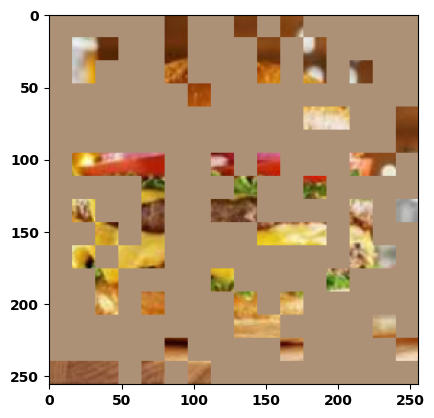

In [15]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the autoencoder
mae = MaskedAutoEncoder()

# Load the model parameters
checkpoint_path = 'checkpoints/mae_epoch388_500.pth'
# checkpoint_path = 'mae_epoch_final.pth'
mae.load_state_dict(torch.load(checkpoint_path))
mae = mae.to(device)  # Move the model to GPU

mae.eval()


def patching_single(img,r=0.75,patch_size=16): # Mask 80% of patches by default
        """Code to create patches to pass to the MAE"""
        # Create patches
        C,H,W = img.shape
        img = img.reshape(C,H//patch_size,patch_size,W//patch_size,patch_size)
        img = img.permute(1,3,0,2,4)
        img = img.flatten(3,4) # torch.Size([16,16,3,256])
        img = img.flatten(2,3) # torch.Size([16, 16, 256*3])
        img = img.flatten(0,1) # torch.Size([256, 256*3])
        return img


scaler = transforms.Resize((256, 256),antialias=True) # Resize the values to make the image square for the
# transformer. 480 is a decent number based on the dimensions of the images in the dataset.
# These mean and std values are of the pacp dataset
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.681, 0.570, 0.467],
                                 std=[0.278, 0.297, 0.332])

img_name = 'D:/fastfooddataset/Fast Food Classification V2/AllValid/Sandwich-Valid (189).jpeg'
# img_name = 'exptwo.jpg'
image = cv.imread(img_name)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert from BGR to RGB
image = normalize(scaler(to_tensor(image)))
imageorig = image.clone()
# Create patches to pass to the masked autoencoder
image = patching_single(image).unsqueeze(0)
image = image.to(device)


# Forward pass through the model
with torch.no_grad():
    output = mae(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


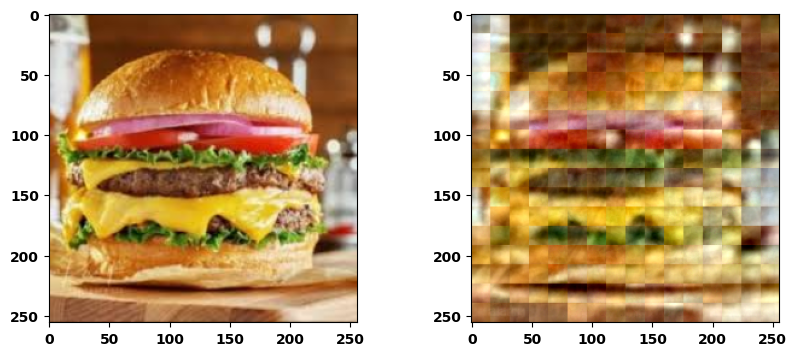

In [16]:
imageorig = imageorig.permute(1,2,0).numpy()
imageorig = imageorig * std + mean  # undo normalization
# plt.imshow(imageorig)

imgrecon = output.squeeze(0)
imgrecon = imgrecon.reshape(16,16,3,16,16)
imgrecon = imgrecon.permute(2,0,3,1,4)
imgrecon = imgrecon.reshape(3,256,256)
imgrecon = imgrecon.cpu().permute(1,2,0).numpy()
imgrecon = imgrecon * std + mean  # undo normalization
# plt.imshow(imgrecon)

plt.figure(figsize=(10, 4))

images = [imageorig,imgrecon]
# Display each image as a subplot
for i, image in enumerate(images):
    plt.subplot(1, len(images), i+1)  # arguments are: nrows, ncols, index
    plt.imshow(image)